# Run the Trained Model

This notebook demonstrates how to load the trained model (`best_model.pth`) and run inference on a test dataset.

## Requirements
- `best_model.pth` file downloaded from the GitHub release
- A `Sliced_Images` directory containing the test images
- A `Sliced_masks` directory containing the corresponding masks


## Steps
1. Set `TEST_DATA_DIR` to your test dataset directory.
2. Set `MODEL_PATH` to the path of your `best_model.pth` file.
3. Run all cells.


In [110]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

## Configuration

Update the paths below as needed.

In [111]:
TEST_DATA_DIR = "/content"
HAS_GT_MASKS = os.path.isdir(os.path.join(TEST_DATA_DIR, 'Sliced_masks'))

images_dir = os.path.join(TEST_DATA_DIR, 'Sliced_Images')
masks_dir = os.path.join(TEST_DATA_DIR, 'Sliced_masks') if HAS_GT_MASKS else None


## Custom Dataset
This dataset will:
- Load images
- Apply normalization and resizing as done during training.


In [112]:
class TestDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transform=None):
        self.images_dir = images_dir
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        # Add a print to verify
        print(f"Found {len(self.image_files)} image files")

        self.masks_dir = masks_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        mask = None
        if self.masks_dir is not None:
            mask_path = os.path.join(self.masks_dir, img_name)
            if os.path.exists(mask_path):
                mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        if mask is not None:
            mask = mask.resize(IMG_SIZE)
            mask = np.array(mask)
            mask = (mask > 127).astype(np.float32)
            mask = torch.from_numpy(mask).unsqueeze(0)

        return image, mask, img_name


## Preprocessing and Normalization

We apply the same preprocessing used during training.


In [113]:
preprocessing = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


## Load the Dataset and Dataloader


In [114]:
def custom_collate_fn(batch):
    images = []
    masks = []
    img_names = []
    for b in batch:
        images.append(b[0])
        masks.append(b[1])
        img_names.append(b[2])

    return images, masks, img_names


In [115]:
images_dir = os.path.join(TEST_DATA_DIR, 'Sliced_Images')
masks_dir = os.path.join(TEST_DATA_DIR, 'Sliced_masks') if HAS_GT_MASKS else None

test_dataset = TestDataset(images_dir=images_dir, masks_dir=masks_dir, transform=preprocessing)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn, drop_last=False)


Found 100 image files


## Load the Model

U-Net++ and EfficientNet-B4 encoder.

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = smp.UnetPlusPlus(
    encoder_name='efficientnet-b4',
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None
)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()


<ipython-input-116-14a413aa21eb>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticS

## Inference and Visualization


In [117]:
def visualize(image_tensor, pred_mask, gt_mask=None, img_name='image.png'):
    # Denormalize the image
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    image = image_tensor.cpu() * std + mean
    image = image.permute(1,2,0).numpy()
    image = np.clip(image, 0, 1)

    pred_mask = pred_mask.cpu().squeeze().numpy()

    if gt_mask is not None:
        gt_mask = gt_mask.cpu().squeeze().numpy()

    if gt_mask is not None:
        fig, axes = plt.subplots(1, 3, figsize=(15,5))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10,5))

    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(image, alpha=0.5)
    axes[1].imshow(pred_mask, cmap='jet', alpha=0.5)
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')

    if gt_mask is not None:
        axes[2].imshow(image, alpha=0.5)
        axes[2].imshow(gt_mask, cmap='jet', alpha=0.5)
        axes[2].set_title('Ground Truth Mask')
        axes[2].axis('off')

    plt.suptitle(img_name)
    plt.show()


### Running Loop

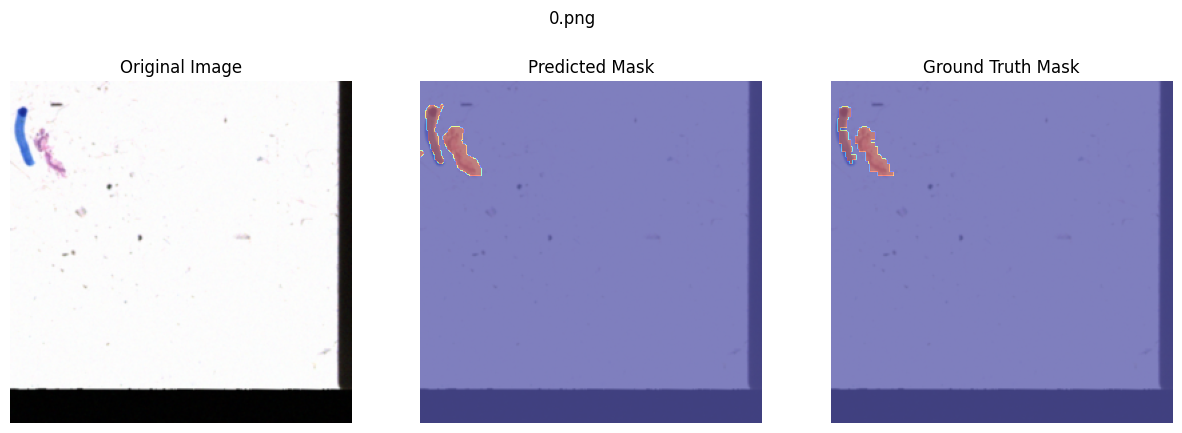

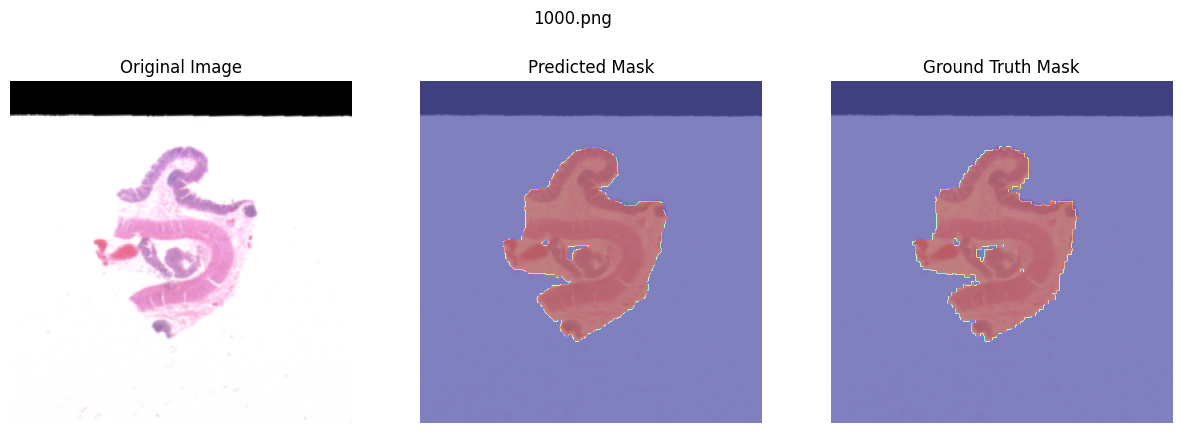

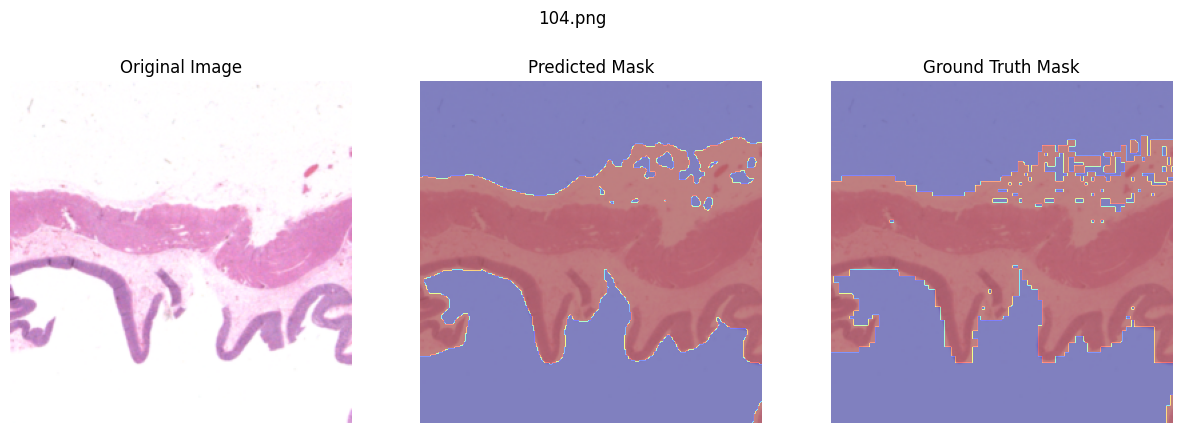

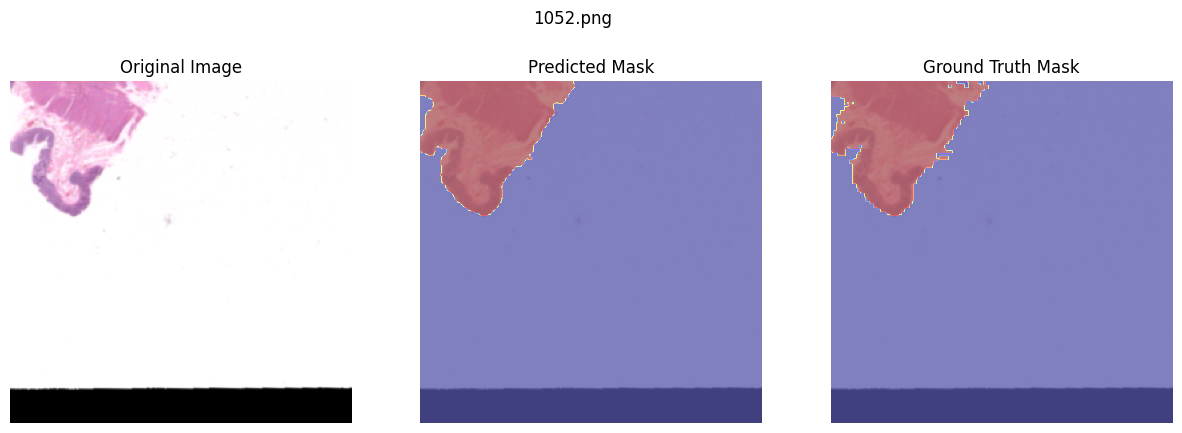

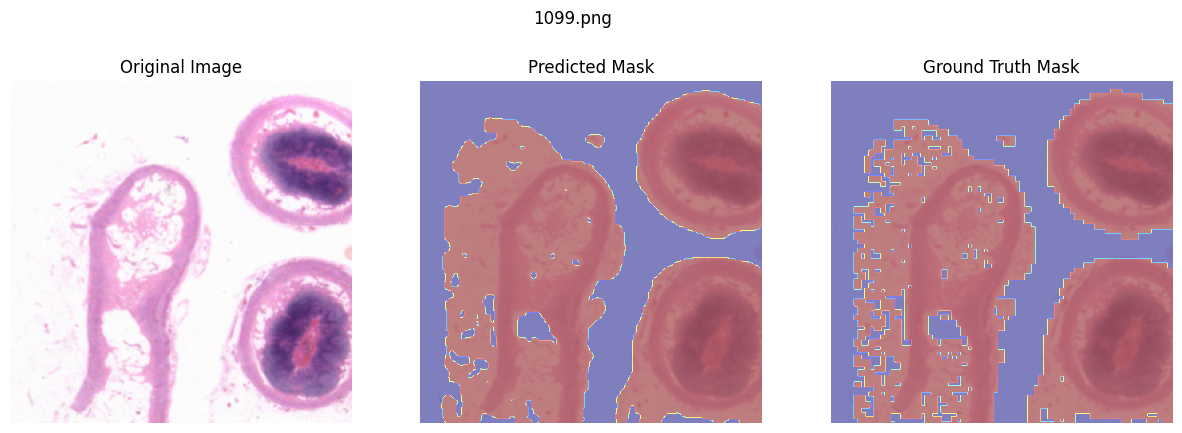

Average IoU on test set: 93.11%


In [118]:
iou_scores = []
visualization_count = 0
MAX_VISUALIZATIONS = 5

for images, masks, img_names in test_loader:
    image = images[0].to(device)
    mask = masks[0] if masks[0] is not None else None
    img_name = img_names[0]

    with torch.no_grad():
        outputs = model(image.unsqueeze(0))
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

    if visualization_count < MAX_VISUALIZATIONS:
        visualize(image, preds[0], gt_mask=mask, img_name=img_name)
        visualization_count += 1

    if mask is not None:
        intersection = (preds[0] * mask).sum()
        union = (preds[0] + mask - preds[0]*mask).sum()
        iou = (intersection / union).item() if union > 0 else 1.0
        iou_scores.append(iou)

if HAS_GT_MASKS and len(iou_scores) > 0:
    avg_iou = sum(iou_scores) / len(iou_scores)
    print(f"Average IoU on test set: {avg_iou * 100:.2f}%")
else:
    print("Inference complete. No ground truth masks provided for IoU calculation.")
